### Target:
- Need to make model efficient by using batch normalization


### Results:
- Parameters: 10.7k
- Best Train Accuracy: 99.75
- Best Test Accuracy: 98.28


### Analysis:
- Need to find techinque to achieve the 99.4% accuracy


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
if 'google.colab' in sys.modules:
# Add the directory containing your module to the Python path
  module_path = '/content/drive/MyDrive/Colab_Notebooks/Session7'
  sys.path.append(module_path)
  print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab_Notebooks/Session7']


# Import Libraries

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


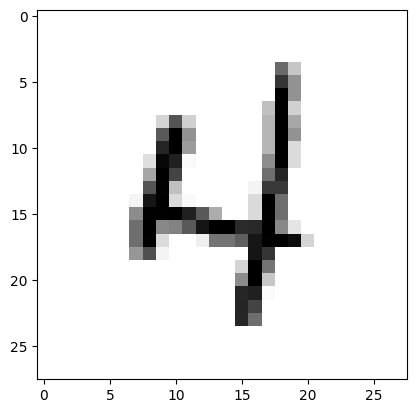

In [7]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [8]:
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                      # Note the difference between (0.1307) and (0.1307,)
                                      ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [9]:
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

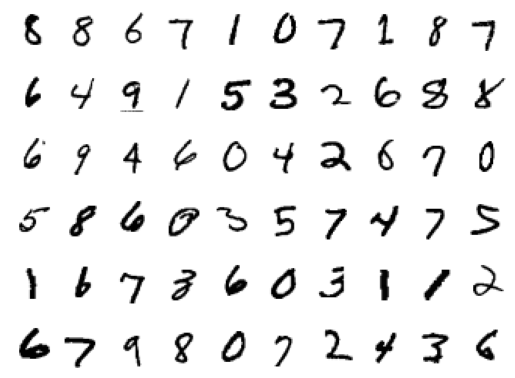

In [10]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [11]:
from models import Model4 as Net ,get_summary

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [12]:
device = torch.device("cuda" if cuda else "cpu")
model =  Net(dropout_value=0).to(device)
get_summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
        MaxPool2d-10           [-1, 20, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             200
      BatchNorm2d-12           [-1, 10, 11, 11]              20
             ReLU-13           [-1, 10, 11, 11]               0
           Conv2d-14             [-1, 1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [13]:
from tqdm import tqdm
from utils import train,test
train_losses = []
train_acc = []
test_losses = []
test_acc = []

# Let's Train and test our model

In [14]:
model =  Net(dropout_value=0).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_acc_temp,train_losses_temp   = train(model, device, train_loader, optimizer, epoch,None)
    test_acc_temp,test_losses_temp = test(model, device, test_loader)
    train_acc.extend(train_acc_temp)
    train_losses.extend(train_losses_temp)
    test_acc.extend(test_acc_temp)
    test_losses.extend(test_losses_temp)

EPOCH: 0


Loss=0.09634324908256531 Batch_id=468 Accuracy=94.44: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]



Test set: Average loss: 0.0605, Accuracy: 9807/10000 (98.07%)

EPOCH: 1


Loss=0.04222453013062477 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:20<00:00, 22.59it/s]



Test set: Average loss: 0.0366, Accuracy: 9880/10000 (98.80%)

EPOCH: 2


Loss=0.051642950624227524 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:18<00:00, 25.68it/s]



Test set: Average loss: 0.0324, Accuracy: 9894/10000 (98.94%)

EPOCH: 3


Loss=0.013084313832223415 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:18<00:00, 25.00it/s]



Test set: Average loss: 0.0344, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.00571161275729537 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 27.31it/s]



Test set: Average loss: 0.0324, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.014061654917895794 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:18<00:00, 24.70it/s]



Test set: Average loss: 0.0278, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.02575673907995224 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]



Test set: Average loss: 0.0254, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.031488027423620224 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]



Test set: Average loss: 0.0231, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.002449994906783104 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]



Test set: Average loss: 0.0263, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Loss=0.0037542590871453285 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:16<00:00, 27.60it/s]



Test set: Average loss: 0.0224, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.025718169286847115 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]



Test set: Average loss: 0.0247, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.07082615792751312 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:16<00:00, 28.88it/s]



Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.005227876827120781 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]



Test set: Average loss: 0.0218, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.020092016085982323 Batch_id=468 Accuracy=99.71: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]



Test set: Average loss: 0.0252, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.009386417455971241 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:16<00:00, 28.76it/s]



Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)



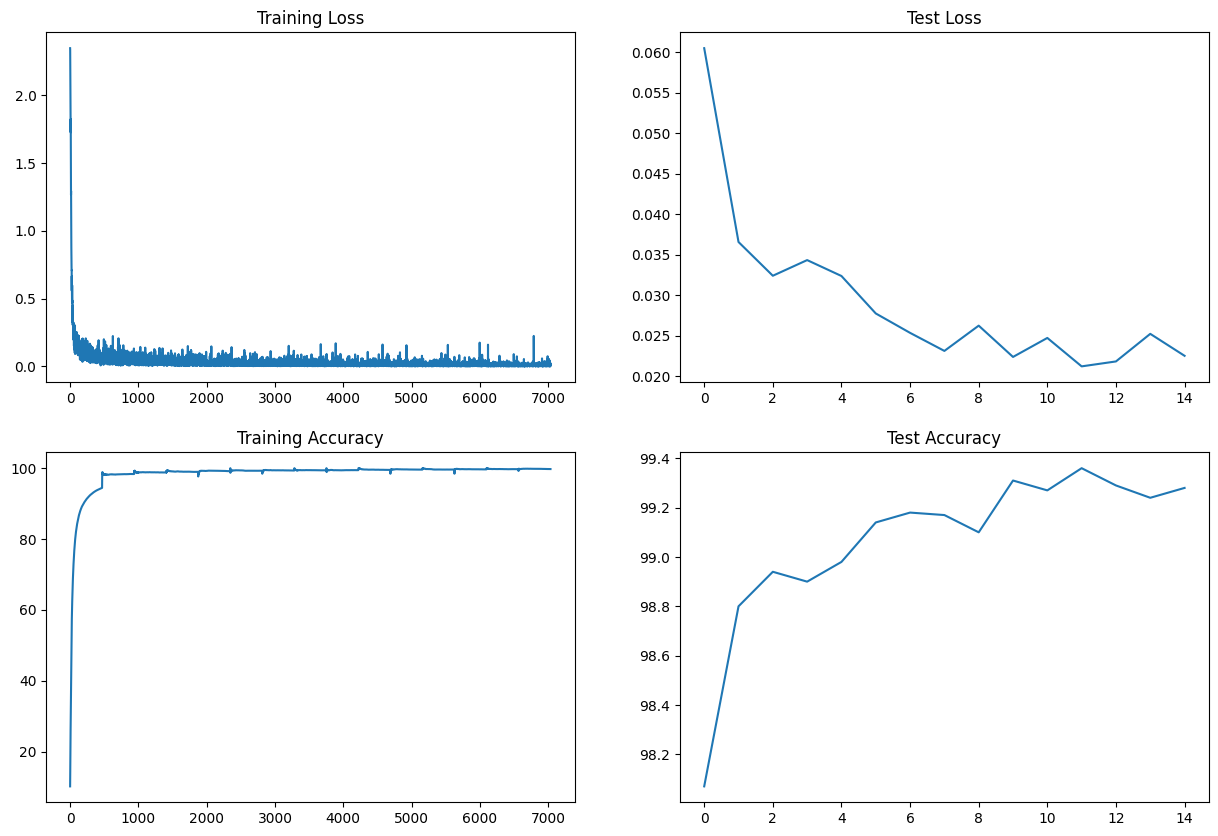

In [15]:
from utils import plot_accuracy_losses,train,test
plot_accuracy_losses(train_losses,train_acc,test_losses,test_acc)

In [17]:
print(train_acc)
print(train_losses)
print(test_acc)
print(test_losses)

[10.15625, 11.71875, 14.322916666666666, 17.578125, 20.0, 22.65625, 24.21875, 26.07421875, 27.95138888888889, 28.984375, 30.96590909090909, 32.942708333333336, 35.39663461538461, 37.94642857142857, 39.583333333333336, 41.455078125, 43.658088235294116, 45.703125, 47.5328947368421, 49.21875, 50.967261904761905, 52.41477272727273, 53.702445652173914, 54.915364583333336, 56.28125, 57.36177884615385, 58.50694444444444, 59.375, 60.39870689655172, 61.015625, 61.743951612903224, 62.548828125, 63.30492424242424, 63.924632352941174, 64.66517857142857, 65.36458333333333, 66.11064189189189, 66.67351973684211, 67.36778846153847, 67.87109375, 68.3498475609756, 68.89880952380952, 69.44040697674419, 69.921875, 70.50347222222223, 70.97486413043478, 71.45944148936171, 71.923828125, 72.30548469387755, 72.640625, 72.93198529411765, 73.33233173076923, 73.76179245283019, 74.10300925925925, 74.43181818181819, 74.76283482142857, 75.15076754385964, 75.44450431034483, 75.72828389830508, 76.10677083333333, 76.42